In [1]:
!pip install transformers

In [2]:
!pip install seaborn

In [3]:
!pip uninstall -y matplotlib
!pip install matplotlib==3.7.3

Found existing installation: matplotlib 3.7.3
Uninstalling matplotlib-3.7.3:
  Successfully uninstalled matplotlib-3.7.3
  Using cached matplotlib-3.7.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.7 kB)
Using cached matplotlib-3.7.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)


In [4]:
import tensorflow as tf
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import DistilBertConfig
from tensorflow.keras.utils import plot_model

model = tf.keras.models.load_model('/mnt/tensorflow_small')

# Check its architecture
model.summary()

2024-01-15 12:30:33.234030: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 12:30:33.234094: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-15 12:30:33.234125: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-15 12:30:33.242071: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-15 12:30:36.275862: I tensor

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 64)]                 0         []                            
                                                                                                  
 input_mask (InputLayer)     [(None, 64)]                 0         []                            
                                                                                                  
 distilbert (TFDistilBertMa  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 inLayer)                    den_state=(None, 64, 768),   0          'input_mask[0][0]']          
                              hidden_states=None, atten                                           
                             tions=None)                                                      

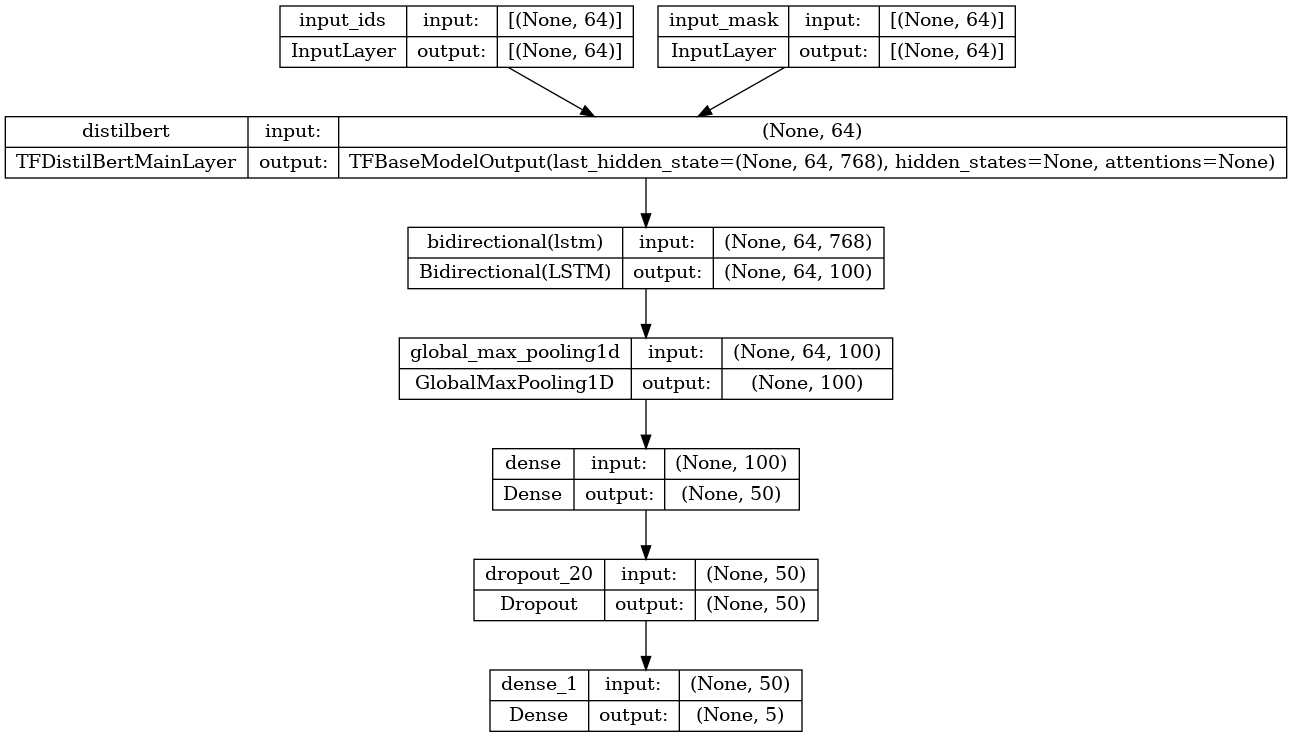

In [5]:
plot_model(model,show_shapes=True)

In [6]:
config = DistilBertConfig.from_pretrained(
    "distilbert-base-uncased",
)

In [7]:
transformer_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", config=config)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [8]:
transformer_model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_38 (Dropout)        multiple                  0         
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


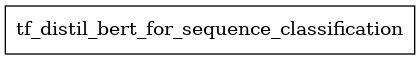

In [9]:
plot_model(transformer_model,show_shapes=True)

In [10]:
max_seq_length = 64

CLASSES = [1, 2, 3, 4, 5]

config = DistilBertConfig.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(CLASSES),
    id2label={0: 1, 1: 2, 2: 3, 3: 4, 4: 5},
    label2id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4},
)
print(config)

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": 1,
    "1": 2,
    "2": 3,
    "3": 4,
    "4": 5
  },
  "initializer_range": 0.02,
  "label2id": {
    "1": 0,
    "2": 1,
    "3": 2,
    "4": 3,
    "5": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.36.2",
  "vocab_size": 30522
}



In [11]:
import pandas as pd
import numpy as np

from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def predict(text):
    encode_plus_tokens = tokenizer.encode_plus(
                            text,
                            pad_to_max_length=True,
                            max_length=max_seq_length,
                            truncation=True,
                            return_tensors='tf')
    
    input_ids = encode_plus_tokens['input_ids']
    input_mask = encode_plus_tokens['attention_mask']
    
    outputs = model.predict(x=(input_ids,input_mask))
    
    prediction = [{"label":config.id2label[item.argmax()], \
                   "socre":item.max().item()} for item in outputs]

    return prediction[0]

In [12]:
predict("This is great!")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 [==============================] - 2s 2s/step


{'label': 5, 'socre': 0.7341577410697937}

In [14]:
df = pd.read_parquet("/mnt/amazon_reviews_2015_small_tail.snappy.parquet",columns=["star_rating","review_id","review_body"])

In [15]:
numOfSample=200
for i in range(1,6):
    new_df = 'df' + str(i)
    globals()[new_df] = df[df['star_rating'] == i].sample(n=numOfSample)

In [21]:
test_df = pd.concat([df1,df2,df3,df4,df5])

In [22]:
test_df.count()

star_rating    1000
review_id      1000
review_body    1000
dtype: int64

In [23]:
test_df

,star_rating,review_id,review_body
321632,1,R2GILL0ENR4J4I,"The grind selection dial did not stay put, and..."
248960,1,R2DQ84K0BROOX6,DOES NOT work on large breed dogs. I am an ex ...
422888,1,R3RS88C5WN4HO2,"I would love to order a few of these shirts, b..."
235377,1,R2UN8PSG5DFHQ1,No stars. It made me pick one at least.<br />D...
126936,1,R1MV4BUV0QLONZ,Made me sick!
...,...,...,...
137207,5,R2EZG5I028CBW2,Great ministry help!
253953,5,RJM9YYDX2FXJU,very good flash light and a good company power...
225949,5,R36JSFGRNA84V1,The best prenatals I've taken. They are gentle...
459866,5,R1X21UHRNHO8CS,Taryn Kincaid's humor and talent to make reade...


In [24]:
y_test = test_df['review_body'].map(predict)
y_true = test_df['star_rating']

1/1 [==============================] - 0s 134ms/step


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 [==============================] - 0s 124ms/step


1/1 [==============================] - 0s 149ms/step


1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 177ms/step


1/1 [==============================] - 0s 160ms/step


1/1 [==============================] - 0s 151ms/step


1/1 [==============================] - 0s 147ms/step


In [25]:
print(type(y_true))
y_true2 = [x for x in y_true.values]

<class 'pandas.core.series.Series'>


In [26]:
print(type(y_true2))
print(y_true2)

<class 'list'>
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [27]:
print(type(y_test))
y_test2 = [x.get('label') for x in y_test.values]

<class 'pandas.core.series.Series'>


In [28]:
print(type(y_test2))
print(y_test2)

<class 'list'>
[2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 5, 3, 2, 2, 1, 1, 1, 1, 1, 4, 5, 4, 4, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 3, 1, 2, 1, 1, 1, 5, 1, 1, 3, 1, 4, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 4, 4, 2, 1, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 4, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 5, 2, 1, 1, 3, 2, 2, 1, 2, 1, 1, 1, 4, 3, 1, 2, 1, 1, 3, 2, 2, 1, 4, 1, 1, 1, 1, 1, 1, 1, 2, 3, 2, 1, 1, 2, 4, 2, 3, 1, 1, 2, 1, 1, 1, 1, 3, 2, 3, 1, 2, 2, 1, 2, 1, 2, 1, 1, 3, 4, 2, 4, 1, 1, 3, 2, 1, 1, 1, 4, 2, 1, 1, 4, 2, 2, 3, 2, 3, 2, 5, 2, 1, 1, 2, 4, 4, 4, 2, 1, 4, 3, 1, 4, 2, 4, 2, 5, 4, 3, 1, 1, 1, 4, 2, 1, 1, 1, 2, 2, 3, 2, 2, 1, 4, 1, 4, 1, 1, 4, 3, 2, 1, 5, 1, 1, 1, 1, 1, 1, 2, 2, 3, 1, 1, 1, 1, 1, 3, 2, 1, 1, 3, 2, 3, 5, 1, 2, 2, 4, 3, 2, 1, 2, 2, 1, 3, 4, 1, 1, 1, 5, 4, 1, 2, 1, 2, 1, 4, 2, 2, 1, 2, 2, 2, 3, 1, 2, 4, 1, 4, 1, 2, 2, 3, 1, 

In [29]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#print(CLASSES)
cm = confusion_matrix(y_true2, y_test2, labels=CLASSES)
cm_df = pd.DataFrame(cm, index=CLASSES, columns=CLASSES)
cm_df

,1,2,3,4,5
1,127,42,16,10,5
2,68,67,27,30,8
3,43,40,58,44,15
4,11,14,26,99,50
5,5,1,9,61,124


In [30]:
arrayX = []
for array in cm:
    temp = []
    # print(array)
    # sumOfValue = array.sum()
    for i in range(len(array)):
        # print(array[i])
        # temp.append(array[i]/sumOfValue)
        temp.append(array[i]/numOfSample)
    arrayX.append(temp)

# print(arrayX)
arrayX_df = pd.DataFrame(arrayX, index=CLASSES, columns=CLASSES)
arrayX_df

,1,2,3,4,5
1,0.635,0.210,0.080,0.050,0.025
2,0.340,0.335,0.135,0.150,0.040
3,0.215,0.200,0.290,0.220,0.075
4,0.055,0.070,0.130,0.495,0.250
5,0.025,0.005,0.045,0.305,0.620


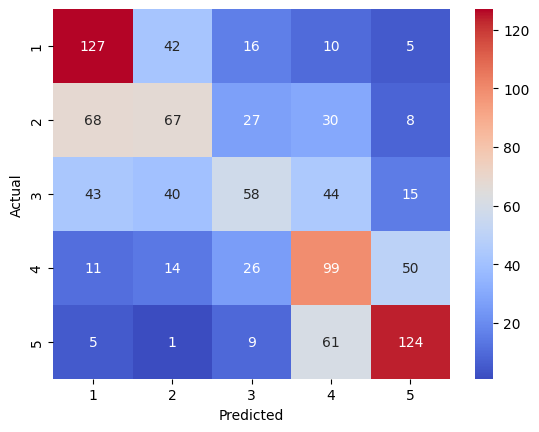

In [31]:
sns.heatmap(cm_df, annot=True, annot_kws={"fontsize":10}, cmap='coolwarm', fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

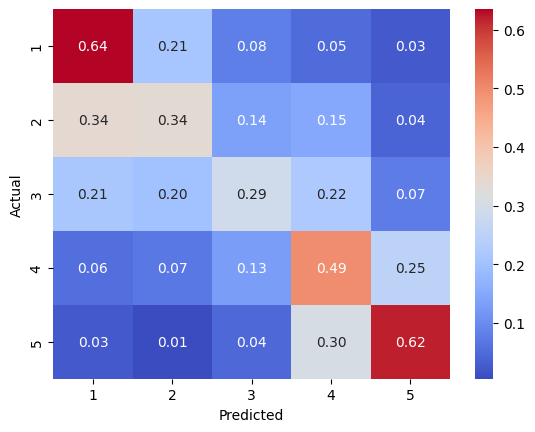

In [32]:
sns.heatmap(arrayX_df, annot=True, annot_kws={"fontsize":10}, cmap='coolwarm', fmt='.2f', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [28]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>